# **Trabalho de Redes Neurais: Detecção de Discurso de Ódio utilizando RoBERTa**

**Objetivo:** Este notebook implementa e avalia um modelo de deep learning baseado na arquitetura Transformer (RoBERTa) para a tarefa de detecção de discurso de ódio em tweets.

**Dataset:** Utiliza-se o MMHS150K, um conjunto de dados com 150.000 tweets contendo texto e imagem. Para esta primeira parte do trabalho, **focaremos exclusivamente na modalidade de texto.**

**Estratégia:**
Após uma análise inicial, observou-se um forte desbalanceamento entre as classes e, com isso, decidiu-se tratar como um problema binário ao invés de multiclasse, que, mesmo assim, ainda mantinha um alto desbalanceamento. O foco principal deste trabalho é, portanto, implementar e comparar duas estratégias distintas para tratar esse desbalanceamento em um problema de classificação binária ("Hate" vs. "Não Hate"):
1. **Método 1:** Undersampling. Balancear o conjunto de treino cortando amostras da classe majoritária.
2. **Método 2:** Perda Ponderada (Weighted Loss). Usar o conjunto de treino completo, mas aplicando pesos na função de perda para dar mais importância à classe minoritária.

O objetivo final é determinar qual das duas abordagens produz um modelo mais eficaz e robusto para a detecção de discurso de ódio.

# **Configuração do Ambiente**

## **Instalações**

In [ ]:
# Controle de versão de bibliotecas
!pip uninstall -y fastai thinc
!pip install numpy==1.26.4 --quiet
!pip install transformers datasets scikit-learn pandas matplotlib --quiet
!pip install --upgrade torch torchvision torchaudio --quiet
!pip install transformers --upgrade --quiet

print("Ambiente configurado. Por favor, REINICIE O AMBIENTE DE EXECUÇÃO antes de prosseguir.")

Found existing installation: fastai 2.7.19
Uninstalling fastai-2.7.19:
  Successfully uninstalled fastai-2.7.19
Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 45.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.8.7 requires thinc<8.4.0,>=8.3.4, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 37.6 MB

### **Lembrete Importante**

**ATENÇÃO:** Após executar a célula de instalação acima, é OBRIGATÓRIO reiniciar o ambiente de execução para que as novas versões das bibliotecas sejam carregadas.
Vá em "Ambiente de execução" (Runtime) -> "Reiniciar sessão" (Restart session).

## **Imports**

In [ ]:
# Imports para manipulação de dados e sistema
import os
import json
import re
from collections import Counter

# Imports das bibliotecas de Machine Learning e Data Science
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Imports da biblioteca Hugging Face
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch import nn

# Import do Kaggle Hub para baixar os dados
import kagglehub

# **Carregamento e Análise Exploratória dos Dados (EDA)**

O primeiro passo da análise é carregar os dados e entender sua estrutura. Realizamos uma análise exploratória na distribuição original de 6 classes para visualizar o desbalanceamento inicial, que motiva a simplificação do problema e a necessidade de técnicas de tratamento.

## **Carregamento dos Dados**

In [ ]:
# Carregamento dos dados

path = kagglehub.dataset_download("victorcallejasf/multimodal-hate-speech")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/multimodal-hate-speech


In [ ]:
print(os.listdir(path))

['splits', 'img_resized', 'img_txt', 'hatespeech_keywords.txt', 'MMHS150K_readme.txt', 'MMHS150K_GT.json']


In [ ]:
# Definição dos caminhos para os arquivos principais
json_gt_path = os.path.join(path, "MMHS150K_GT.json")
splits_paths = {
    "Treino": os.path.join(path, "splits", "train_ids.txt"),
    "Validação": os.path.join(path, "splits", "val_ids.txt"),
    "Teste": os.path.join(path, "splits", "test_ids.txt"),
}

# Carregando o arquivo JSON principal com todas as anotações
with open(json_gt_path, 'r') as f:
    full_data_json = json.load(f)

print("Dados carregados.")


Dados carregados.


## **Análise da Distribuição Multiclasse Original**

Distribuição Original das Classes (Multiclasse):
       Classe  Quantidade
1  Não é hate      108462
0     Racista       11333
4       Outro        6528
2     Sexista        4298
3  Homofóbico        3922
5    Religião         280


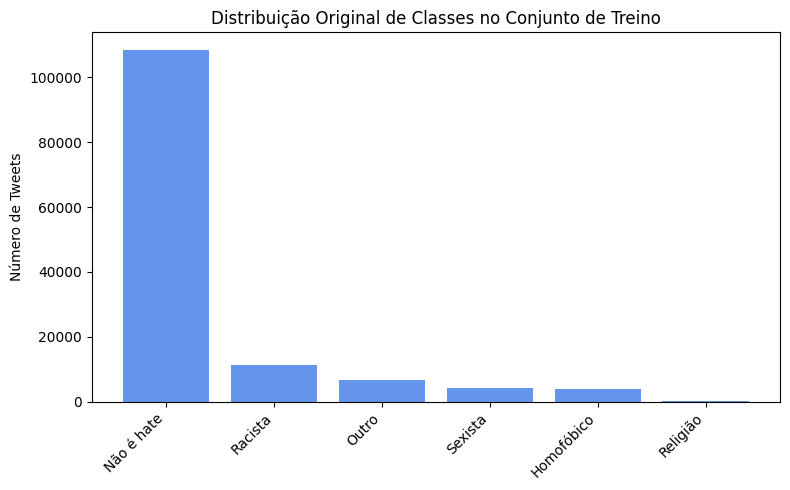

In [ ]:
# Análise da distribuição original (6 Classes)

# Carregando os IDs de treino
with open(splits_paths['Treino'], 'r') as f:
    train_ids = [line.strip() for line in f.readlines()]

# Calculando o voto majoritário para cada tweet no conjunto de treino
original_train_labels = []
for tweet_id in train_ids:
    if tweet_id in full_data_json:
        label_list = full_data_json[tweet_id]['labels']
        most_common = Counter(label_list).most_common(1)[0][0]
        original_train_labels.append(most_common)

# Mapeamento para nomes legíveis
labels_map_multiclass = {
    0: "Não é hate", 1: "Racista", 2: "Sexista",
    3: "Homofóbico", 4: "Religião", 5: "Outro"
}

# Conta e plota a distribuição
original_label_counts = Counter(original_train_labels)
df_dist_multi = pd.DataFrame({
    'Classe': [labels_map_multiclass[label] for label, count in original_label_counts.items()],
    'Quantidade': [count for label, count in original_label_counts.items()]
}).sort_values(by='Quantidade', ascending=False)

print("Distribuição Original das Classes (Multiclasse):")
print(df_dist_multi)

# Plotando o gráfico
plt.figure(figsize=(8, 5))
plt.bar(df_dist_multi['Classe'], df_dist_multi['Quantidade'], color='cornflowerblue')
plt.title('Distribuição Original de Classes no Conjunto de Treino')
plt.ylabel('Número de Tweets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# **Pré-processamento e Transformação dos Dados**

Com base na análise anterior, simplificamos o problema de 6 classes para uma classificação binária, que é mais direta e relevante para a moderação de conteúdo. Os passos abaixo são aplicados a todo o conjunto de dados e servem como uma base comum para os dois métodos de treinamento que serão comparados.

Fluxo de Processamento:
1. Limpeza do Texto: Remoção de URLs, menções (@) e hashtags (#).
2. Binarização dos Rótulos: Conversão dos 6 rótulos originais para um formato binário: 0 para "Não Hate" e 1 para "Hate".
3. Tokenização: Preparação do texto limpo para o formato que o modelo RoBERTa entende.

In [ ]:
# Funções de pré-processamento

def clean_text(text):
    """Remove menções, hashtags, URLs e espaços extras do texto."""
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def process_and_binarize_example(example):
    """Aplica a limpeza e a binarização."""
    # Limpa o texto
    example['text'] = clean_text(example['text'])

    # Calcula o voto majoritário
    majority_vote = Counter(example['labels_multi']).most_common(1)[0][0]

    # Binariza o rótulo: 0 para "Não é hate", 1 para qualquer tipo de "Hate"
    example['label'] = 0 if majority_vote == 0 else 1

    return example

# Carregando o tokenizador do modelo que vamos usar
model_checkpoint = "cardiffnlp/twitter-roberta-base-offensive"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    """Aplica a tokenização aos textos."""
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
# Aplicando o fluxo de processamento

# Estruturando os dados brutos em um formato da biblioteca `datasets`
all_data_list = [{'tweet_id': k, 'text': v['tweet_text'], 'labels_multi': v['labels']} for k, v in full_data_json.items()]
full_dataset = Dataset.from_list(all_data_list)

# Filtrando para criar os splits
split_ids_set = {k.lower(): set(open(v, 'r').read().splitlines()) for k, v in splits_paths.items()}
raw_datasets = DatasetDict({
    'train': full_dataset.filter(lambda x: x['tweet_id'] in split_ids_set['treino']),
    'validation': full_dataset.filter(lambda x: x['tweet_id'] in split_ids_set['validação']),
    'test': full_dataset.filter(lambda x: x['tweet_id'] in split_ids_set['teste'])
})

# Aplicando a limpeza e binarização
processed_datasets = raw_datasets.map(process_and_binarize_example, remove_columns=['labels_multi', 'tweet_id'])

# Aplicando a tokenização
tokenized_datasets = processed_datasets.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

# Definindo os datasets finais para o Trainer
train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

print("Pipeline de processamento concluído.")
print("\nEstrutura do Dataset Final:")
print(tokenized_datasets)

Filter:   0%|          | 0/149823 [00:00<?, ? examples/s]

Filter:   0%|          | 0/149823 [00:00<?, ? examples/s]

Filter:   0%|          | 0/149823 [00:00<?, ? examples/s]

Map:   0%|          | 0/134823 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/134823 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Pipeline de processamento concluído.

Estrutura do Dataset Final:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 134823
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
})


Distribuição das Classes Após Binarização:
     Classe  Quantidade
0      Hate       26361
1  Não Hate      108462

Proporção 'Não Hate': 80.45%
Proporção 'Hate':     19.55%


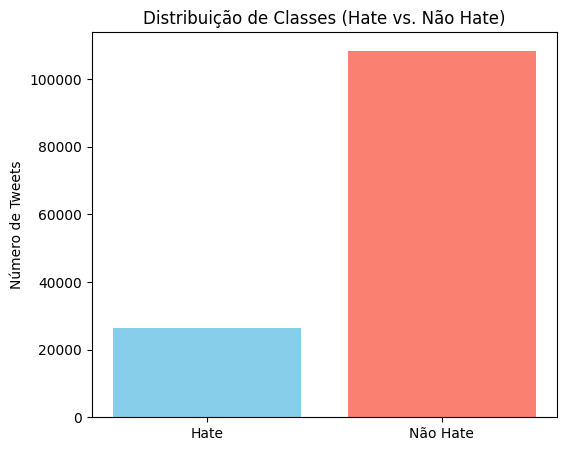

In [ ]:
# Análise de Distribuição Binária
train_labels_binary = processed_datasets['train']['label']
binary_labels_map = {0: "Não Hate", 1: "Hate"}
binary_label_counts = Counter(train_labels_binary)

df_binary_dist = pd.DataFrame({
    'Classe': [binary_labels_map[label] for label in binary_label_counts.keys()],
    'Quantidade': list(binary_label_counts.values())
})

print("Distribuição das Classes Após Binarização:")
print(df_binary_dist)
print(f"\nProporção 'Não Hate': {binary_label_counts[0] / len(train_labels_binary):.2%}")
print(f"Proporção 'Hate':     {binary_label_counts[1] / len(train_labels_binary):.2%}")

plt.figure(figsize=(6, 5))
plt.bar(df_binary_dist['Classe'], df_binary_dist['Quantidade'], color=['skyblue', 'salmon'])
plt.title('Distribuição de Classes (Hate vs. Não Hate)')
plt.ylabel('Número de Tweets')
plt.show()

# **Comparativo de Estratégias para Tratamento de Desbalanceamento**

A análise da distribuição binária confirma o desbalanceamento (aprox. 80% "Não Hate" e 20% "Hate"). A seguir, vamos treinar e avaliar o modelo usando duas abordagens distintas para lidar com essa questão.

## **Método 1: Treinamento com Base Balanceada (Undersampling)**

Nesta abordagem, criamos um novo conjunto de treino artificialmente balanceado. Removemos aleatoriamente amostras da classe majoritária ("Não Hate") até que ela tenha o mesmo número de amostras da classe minoritária ("Hate").

* Vantagem: Simplicidade e um treinamento mais rápido.
* Desvantagem: Perda significativa de dados, o que pode fazer com que o modelo não aprenda todas as nuances da classe "Não Hate".

Importante: O undersampling é aplicado apenas ao conjunto de treino. Os conjuntos de validação e teste permanecem com a distribuição original para que a avaliação do modelo reflita o mundo real.

Distribuição das Classes no Treino Após Undersampling:
label
1    26361
0    26361
Name: count, dtype: int64


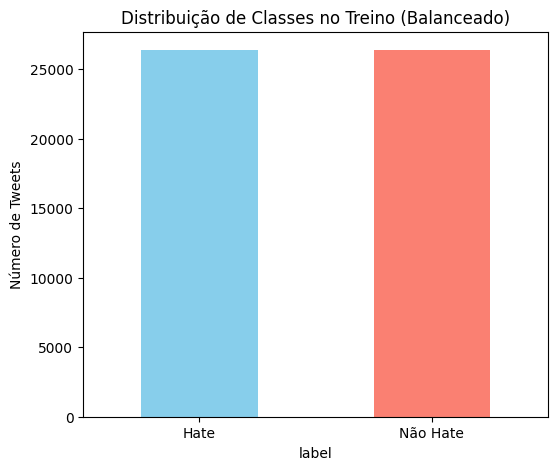

In [ ]:
# Aplicando undersampling ao conjunto de treino

# Convertendo o conjunto de treino para um DataFrame do Pandas, que facilita a manipulação
df_train = processed_datasets['train'].to_pandas()

# Separando as classes
df_hate = df_train[df_train['label'] == 1]
df_not_hate = df_train[df_train['label'] == 0]

# Cortando a classe majoritária ("Não Hate") para ter o mesmo tamanho da minoritária
n_hate_samples = len(df_hate)
df_not_hate_undersampled = df_not_hate.sample(n=n_hate_samples, random_state=42) # random_state para reprodutibilidade

# Juntando as duas partes e embaralhando
df_train_balanced = pd.concat([df_hate, df_not_hate_undersampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Distribuição das Classes no Treino Após Undersampling:")
print(df_train_balanced['label'].value_counts())

# Convertendo o DataFrame balanceado de volta para um Dataset
balanced_train_dataset = Dataset.from_pandas(df_train_balanced)

# Plotando a nova distribuição para confirmar
plt.figure(figsize=(6, 5))
df_train_balanced['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribuição de Classes no Treino (Balanceado)')
plt.xticks(ticks=[0, 1], labels=['Hate', 'Não Hate'], rotation=0)
plt.ylabel('Número de Tweets')
plt.show()

In [ ]:
def compute_binary_metrics(pred):
    """Calcula métricas focadas no problema binário."""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Usamos average='binary' para focar na performance da classe positiva (1: "Hate")
    f1 = f1_score(labels, preds, average='binary')
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)

    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [ ]:
# Treinamento com a base balanceada


# Tokeniza o novo dataset de treino balanceado
tokenized_balanced_train_dataset = balanced_train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_balanced_train_dataset = tokenized_balanced_train_dataset.rename_column("label", "labels")
tokenized_balanced_train_dataset.set_format("torch")


# Argumentos para este experimento
training_args_undersampled = TrainingArguments(
    output_dir="./results/roberta-undersampled",
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

# Instanciando o Trainer
trainer_undersampled = Trainer(
    model=AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2),
    args=training_args_undersampled,
    train_dataset=tokenized_balanced_train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_binary_metrics,
    tokenizer=tokenizer
)

print("Iniciando o treinamento com Undersampling...")
trainer_undersampled.train()
results_undersampled = trainer_undersampled.evaluate(test_dataset)
print("\nResultados com Undersampling:")
print(results_undersampled)

Map:   0%|          | 0/52722 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/tmp/ipython-input-17-2995738941.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_undersampled = Trainer(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Iniciando o treinamento com Undersampling...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.621200,0.617282,0.685000,0.613876,0.682661,0.557684
2,0.594600,0.625159,0.677800,0.633113,0.647717,0.619154
3,0.546900,0.660317,0.672600,0.631223,0.638560,0.624053



Resultados com Undersampling:
{'eval_loss': 0.6361916065216064, 'eval_accuracy': 0.67, 'eval_f1': 0.6248294679399727, 'eval_precision': 0.6289768825818265, 'eval_recall': 0.6207363903320533, 'eval_runtime': 59.3606, 'eval_samples_per_second': 168.462, 'eval_steps_per_second': 2.645, 'epoch': 3.0}



Gerando previsões para a Matriz de Confusão com Undersampling...


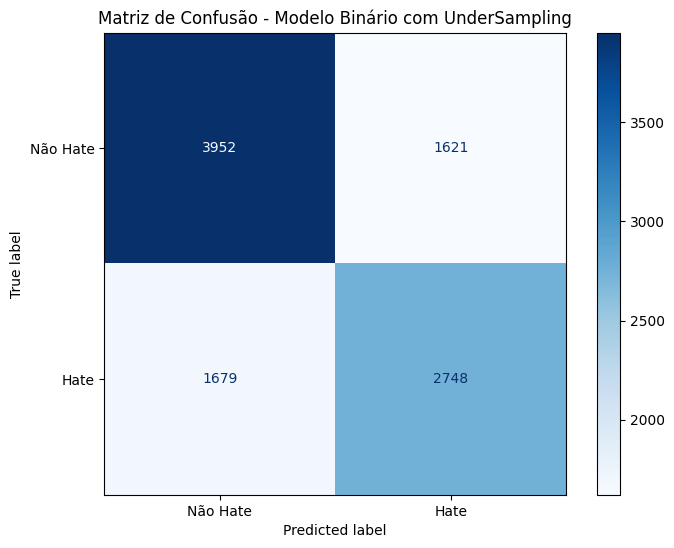

In [ ]:
# Análise Visual com Matriz de Confusão

print("\nGerando previsões para a Matriz de Confusão com Undersampling...")
predictions = trainer_undersampled.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Gera e plota a matriz
cm = confusion_matrix(labels, preds, labels=list(binary_labels_map.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(binary_labels_map.values()))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", values_format='d', ax=ax)
plt.title("Matriz de Confusão - Modelo Binário com UnderSampling")
plt.grid(False)
plt.show()

## **Método 2: Treinamento com Base Completa e Pesos (Weighted Loss)**

Nesta abordagem, usamos todos os dados de treino, mas instruímos o modelo a dar mais importância à classe minoritária durante o cálculo da perda. A "punição" por um erro em uma amostra de "Hate" é maior, forçando o modelo a prestar mais atenção nela.

* Vantagem: Nenhuma informação é descartada, utilizando todo o poder dos dados.
* Desvantagem: Requer uma implementação um pouco mais complexa e um treinamento mais demorado, com um Trainer customizado.

In [ ]:
# Cálculo dos pesos
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_binary),
    y=train_labels_binary
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Pesos calculados para as classes [0, 1]: {class_weights}")

# Definição de treinamento customizado
class WeightedTrainer(Trainer):
    """Um Trainer customizado que usa pesos de classe na função de perda."""
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

Pesos calculados para as classes [0, 1]: [0.62152182 2.55724366]


In [ ]:
# Configuração do Modelo, Métricas e Argumentos

# Carrega o modelo para classificação binária
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

# Argumentos para o treinamento
training_args = TrainingArguments(
    output_dir="./results/roberta-binary-weighted-final",
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir="./logs/roberta-binary-weighted-final",
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1", # Foco na métrica F1 da classe "Hate"
    report_to="none"
)

# Instancia o nosso Trainer customizado com os pesos
trainer_weighted = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_binary_metrics,
    class_weights=class_weights_tensor
)

print("Configuração de treinamento pronta.")

Configuração de treinamento pronta.


In [ ]:
# Treinamento e Avaliação

print("Iniciando o treinamento com pesos...")
trainer_weighted.train()

print("\nIniciando a avaliação final no conjunto de teste com pesos...")
results_weighted = trainer_weighted.evaluate(test_dataset)
print("\nResultados da Avaliação no Teste com pesos:")
print(results_weighted)

Iniciando o treinamento com pesos...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.606000,0.640029,0.678800,0.641037,0.643338,0.638753
2,0.562600,0.675838,0.684200,0.607702,0.687079,0.544766



Iniciando a avaliação final no conjunto de teste com pesos...



Resultados da Avaliação no Teste com pesos:
{'eval_loss': 0.6530072093009949, 'eval_accuracy': 0.6669, 'eval_f1': 0.6283610398304139, 'eval_precision': 0.6208112874779541, 'eval_recall': 0.6360966794669076, 'eval_runtime': 59.6652, 'eval_samples_per_second': 167.602, 'eval_steps_per_second': 2.631, 'epoch': 2.0}



Gerando previsões para a Matriz de Confusão...


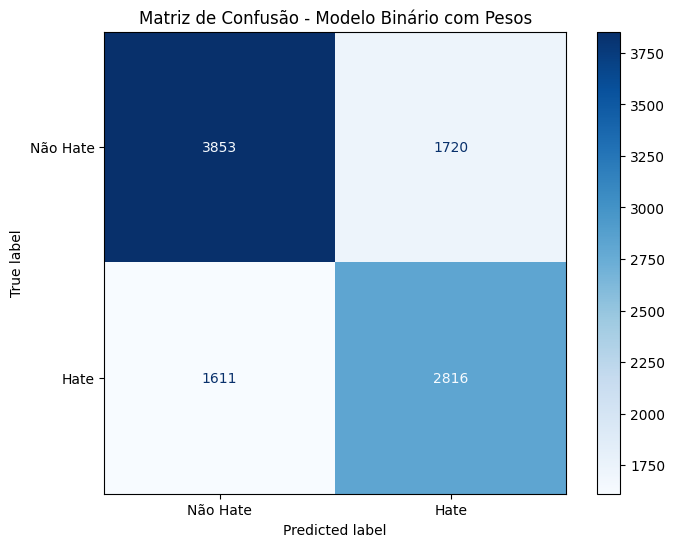

In [ ]:
# Análise Visual com Matriz de Confusão

print("\nGerando previsões para a Matriz de Confusão...")
predictions = trainer_weighted.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Gera e plota a matriz
cm = confusion_matrix(labels, preds, labels=list(binary_labels_map.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(binary_labels_map.values()))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", values_format='d', ax=ax)
plt.title("Matriz de Confusão - Modelo Binário com Pesos")
plt.grid(False)
plt.show()

# **Comparação Final e Conclusão**

A tabela comparativa abaixo revela que ambos os métodos foram moderadamente eficazes em forçar o modelo a aprender a identificar a classe minoritária "Hate". No entanto, observam-se trade-offs importantes:
* **Recall vs. Precisão:** O Método 2 (Weighted Loss) alcançou um Recall superior (0.636 vs. 0.620), indicando uma maior capacidade de identificar corretamente os casos de "Hate" e minimizar os falsos negativos. Em contrapartida, o Método 1 (Undersampling) obteve uma Precisão ligeiramente maior (0.628 vs. 0.620), sugerindo que, quando ele classifica um tweet como "Hate", seu julgamento é um pouco mais confiável, cometendo menos erros de falsos positivos.
* **Performance Geral vs Custo Computacional:** Embora o Método 2 (Weighted Loss) tenha apresentado um F1-Score marginalmente superior (0.628 vs. 0.625), que é a métrica que melhor equilibra precisão e recall, seu custo computacional foi consideravelmente mais alto, pois treinou com o dataset completo (cerca de 135.000 amostras). O Método 1 (Undersampling) treinou em uma base muito menor (cerca de 52.000 amostras), resultando em um tempo de treinamento drasticamente reduzido.

**Conclusão Final para o RoBERTa:**
Considerando que em um problema de moderação de conteúdo é frequentemente preferível ter um recall maior (garantir que o conteúdo de ódio seja pego), e com a vantagem teórica de não descartar dezenas de milhares de dados de treinamento, na teoria, o método de Weighted Loss se apresenta como a solução mais robusta.

Entretanto, como a diferença na performance final foi mínima, a enorme vantagem em eficiência e custo computacional torna o método de Undersampling uma alternativa muito atraente e pragmática, especialmente em cenários com recursos limitados. A escolha final entre os dois para o fine-tuning do RoBERTa neste dataset dependeria do objetivo prioritário do sistema: maximizar a detecção a qualquer custo (Weighted Loss) ou obter uma performance muito similar com muito mais rapidez (Undersampling).

In [ ]:
# Comparação Final

# Criando a tabela
comparison_data = {
    "Métrica": ["F1", "Recall", "Precisão", "Acurácia Geral"],
    "Método 1 (Undersampling)": [
        results_undersampled.get('eval_f1'),
        results_undersampled.get('eval_recall'),
        results_undersampled.get('eval_precision'),
        results_undersampled.get('eval_accuracy')
    ],
    "Método 2 (Weighted Loss)": [
        results_weighted.get('eval_f1'),
        results_weighted.get('eval_recall'),
        results_weighted.get('eval_precision'),
        results_weighted.get('eval_accuracy')
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("Tabela Comparativa dos Métodos de Balanceamento")
display(df_comparison)


Tabela Comparativa dos Métodos de Balanceamento


,Métrica,Método 1 (Undersampling),Método 2 (Weighted Loss)
0,F1,0.624829,0.628361
1,Recall,0.620736,0.636097
2,Precisão,0.628977,0.620811
3,Acurácia Geral,0.670000,0.666900
